# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [ ]:
import warnings
from typing import Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [2]:
with open(r"/home/an/Downloads/anek.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [3]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [4]:
cut_text = cut_data(text)

In [5]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [6]:
unique_chars = tuple(set(text))
print(unique_chars)
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}

('г', 'к', 'a', 'а', 'К', 'х', 'Q', 'З', '4', 'i', 'j', 'Х', 'В', '%', 'Ц', 'й', '最', '果', 'Щ', 'з', 'ч', '>', 'о', '9', 'n', 'Ø', '^', 'ы', 'с', 'Ю', 'Й', 'Э', '▒', 'e', 'ё', 'ф', '+', 'Д', 'Я', 'Ы', '=', '-', 'П', 'f', 'ь', 'я', 'W', 'w', '7', 'O', '选', '?', 'g', 'M', ';', 'Ь', '€', 'И', '“', '×', 'л', 'F', 'д', 'у', '!', 'A', '6', 'R', '然', 'x', 'r', 'Е', 'ц', 'E', '¿', '@', 'Н', 'ж', '$', '_', 'T', 'P', 'v', 'd', 'U', '°', 'У', '副', 'X', 'ю', 'D', 'ш', '名', 'y', 'K', '|', '数', '3', 'р', 'Ж', '会', 'и', '直', '，', 'Z', 'э', '/', '并', 'А', ',', '<', '"', '的', '。', 'V', '新', 'Т', '给', '手', 'p', '由', 'S', '老', 'C', 'π', '́', 'м', 'h', 'ο', '»', 'b', 'm', 'Ш', 'I', '☺', '*', 'п', 'н', '命', 'c', 'щ', '表', 'N', '为', 'С', 'Р', '5', '̆', '”', '人', 'L', 'М', '经', 'т', 'k', 'H', '\ufeff', 's', '2', '&', '任', '接', '″', 'Ф', '\u200b', '\n', 'Г', '结', 'Y', 'Л', '1', '0', 'l', 'J', ' ', 'е', '²', '̈', 'ö', '№', '☻', 'Ч', 'ъ', 'B', '举', '应', 't', 'Ъ', '理', 'О', '代', '成', '事', 'ë', '8', 'G', '虽', 'б'

Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [7]:
def encode(sentence, vocab):
    l = []
    for ch in sentence:
        l.append(vocab[ch])
    return l

def decode(tokens, vocab):
    l = ""
    for tok in tokens:
        l += vocab[tok]
    return l

a = encode("sdfsdf asdfasdasdkslf sdfkh asdf", char2int)
print(a)
b = decode(a, int2char)
print(b)

[157, 83, 43, 157, 83, 43, 174, 2, 157, 83, 43, 2, 157, 83, 2, 157, 83, 154, 157, 172, 43, 174, 157, 83, 43, 154, 127, 174, 2, 157, 83, 43]
sdfsdf asdfasdasdkslf sdfkh asdf


Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:
![alt_text](../additional_materials/images/char_rnn.jfif)

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [8]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values"""
    batch_size, seq_len = int_words.shape
    words_one_hot = torch.zeros((batch_size, seq_len, vocab_size))
    
    for batch_idx in range(batch_size):
        words_one_hot[batch_idx, torch.arange(seq_len), int_words[batch_idx]] = 1.0
    return words_one_hot

Проверьте ваш код.

In [9]:
test_seq = torch.tensor([[2, 6, 4, 1], [0,3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [10]:
class Tokenizer:
    def __init__(self, text):
        self.text = text
        self.unique_chars = list(set(text))
        self._add_special("<pad>")
        self._add_special("<bos>")
        self._add_special("<eos>")
        
        self.int2char = dict(enumerate(self.unique_chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
    
    def _add_special(self, symbol) -> None:
        if symbol not in self.unique_chars:
            self.unique_chars.append(symbol)

    @property
    def vocab_size(self):
        return len(self.unique_chars)
        
    def decode_symbol(self, el):
        return self.int2char[el]
        
    def encode_symbol(self, el):
        return self.char2int[el]

    def encode(self, chars):
        chars = ["<bos>"] + list(chars) + ["<eos>"]
        return [self.encode_symbol(ch) for ch in chars]

    def decode(self, idx):
        chars = [self.decode_symbol(i) for i in idx]
        return ''.join([ch for ch in chars if ch not in ["<bos>", "<eos>"]])


In [11]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")

    def __len__(self):
        return len(self.cut_text)
        
    def __getitem__(self, item):
        joke = self.cut_text[item]
        encoded_joke = self.tokenizer.encode(joke)

        if len(encoded_joke) > self.max_len:
            encoded_joke = encoded_joke[:self.max_len]

        padding_num = self.max_len - len(encoded_joke)
        padded_joke = encoded_joke + [self.pad_index] * padding_num

        return torch.tensor(padded_joke), len(encoded_joke)


In [12]:
batch_size = 32
seq_length = 512
n_hidden = 64
n_layers = 4
drop_prob = 0.1
lr = 0.1

In [13]:
tokenizer = Tokenizer(text)
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [14]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.n_hidden = hidden_dim
        self.n_layers = num_layers
        self.max_len = max_len
        self.tokenizer = tokenizer
        
        vocab_size = self.tokenizer.vocab_size
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=self.n_hidden, num_layers=self.n_layers, dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(self.n_hidden, vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.shape
        # h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device) there is no need to init hidden tensor, Pety said...

        one_hot = one_hot_encode(x, self.tokenizer.vocab_size)

        packed_embeds = pack_padded_sequence(one_hot, lengths, batch_first=True, enforce_sorted=False).to(device)
        packed_output, hidden = self.rnn(packed_embeds)
        out, lengths = pad_packed_sequence(packed_output, batch_first=True, total_length=seq_len, 
                                           padding_value=self.tokenizer.encode_symbol('<pad>'))
        logits = self.fc(out)

        return logits, hidden

    def inference(self, prefix=""):
        print(self.tokenizer.encode(prefix))
        tokens = torch.tensor(self.tokenizer.encode(prefix))[: -1].unsqueeze(0).to(device)
        inputs = one_hot_encode(tokens, self.tokenizer.vocab_size).to(device)
        h0 = torch.zeros(self.n_layers, 1, self.n_hidden).to(device)
        outputs, hidden = self.rnn(inputs, h0)
        print(outputs.shape)
        logits = self.fc(outputs)
        print(logits.shape)
        print(logits[:, -1, :].shape)
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        new_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, new_token], dim=1)
        k = 0
        while tokens.size(1) < self.max_len and new_token.item() != self.tokenizer.encode_symbol('<eos>'):
            k += 1
            inputs = one_hot_encode(new_token, self.tokenizer.vocab_size).to(device)
            outputs, hidden = self.rnn(inputs, hidden)
            logits = self.fc(outputs)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)
        print(k)

        return self.tokenizer.decode(tokens.squeeze().tolist())


Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [15]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    optimizer.zero_grad()

    input_data, target_lengths = train_batch

    input_data = input_data.to(device)

    logits, _ = model(input_data, target_lengths)

    logits = logits.view(-1, vocab_size)

    target_data = input_data.roll(shifts=-1, dims=1)


    help_tensor = torch.zeros([target_data.shape[0], 1], dtype=torch.int64)
    for i in range(target_data.shape[0]):
            help_tensor[i][0] = tokenizer.encode_symbol("<pad>")

    target_data = torch.cat([target_data[:, : -1], help_tensor.to(device)], dim=1).view(-1)

    # mask = target_data != tokenizer.encode_symbol("<pad>")
    # logits = logits[mask]
    # target_data = target_data[mask]

    loss = criterion(logits, target_data)

    loss.backward()
    optimizer.step()

    return loss

Инициализируйте модель, функцию потерь и оптимизатор.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.encode_symbol("<pad>"))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [17]:
model.eval()  

prefix = "dfl;gdkflgj"
# prefix = "<bos>"
# prefix = "<eos>" 
generated_text = model.inference(prefix)
print("Output:", generated_text)

[215, 83, 43, 172, 54, 52, 83, 154, 43, 172, 52, 10, 216]
torch.Size([1, 12, 64])
torch.Size([1, 12, 217])
torch.Size([1, 217])
21
Output: dfl;gdkflgjщ=任6T|Gу»T8GС并代H7́fjъ


In [18]:
def plot_losses(losses):
    clear_output()
    
    losses_cpu = [loss.cpu().item() for loss in losses] 
    
    plt.plot(range(1, len(losses_cpu) + 1), losses_cpu)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

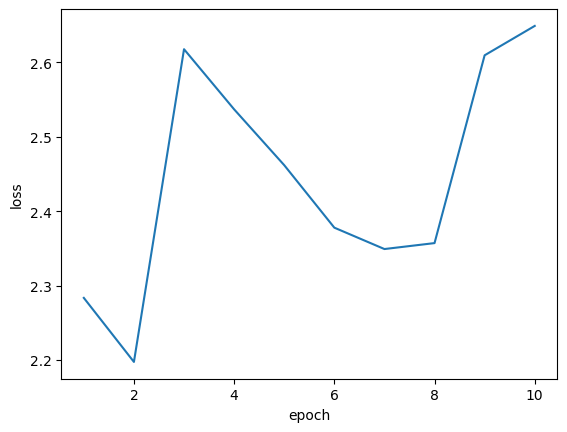

In [19]:
losses = []
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()  
    epoch_loss = 0
        
    for train_batch in tqdm(dataloader):
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss
        
    avg_epoch_loss = epoch_loss / len(dataloader)
    losses.append(avg_epoch_loss)  
    print(avg_epoch_loss)
    
    plot_losses(losses)

In [20]:
[model.inference("") for _ in range(10)]

[215, 216]
torch.Size([1, 1, 64])
torch.Size([1, 1, 217])
torch.Size([1, 217])
75
[215, 216]
torch.Size([1, 1, 64])
torch.Size([1, 1, 217])
torch.Size([1, 217])
43
[215, 216]
torch.Size([1, 1, 64])
torch.Size([1, 1, 217])
torch.Size([1, 217])
268
[215, 216]
torch.Size([1, 1, 64])
torch.Size([1, 1, 217])
torch.Size([1, 217])
25
[215, 216]
torch.Size([1, 1, 64])
torch.Size([1, 1, 217])
torch.Size([1, 217])
21
[215, 216]
torch.Size([1, 1, 64])
torch.Size([1, 1, 217])
torch.Size([1, 217])
89
[215, 216]
torch.Size([1, 1, 64])
torch.Size([1, 1, 217])
torch.Size([1, 217])
188
[215, 216]
torch.Size([1, 1, 64])
torch.Size([1, 1, 217])
torch.Size([1, 217])
500
[215, 216]
torch.Size([1, 1, 64])
torch.Size([1, 1, 217])
torch.Size([1, 217])
392
[215, 216]
torch.Size([1, 1, 64])
torch.Size([1, 1, 217])
torch.Size([1, 217])
19


['Жучери! О прош. Ненимь с комол, стярон зехри раби порослостоя ожнажо? зика?',
 'Неч митакно насвот нейспее ваква?- Поснева.',
 'Етнош?- Зуст, махротния, ожддом кту вебають не на нобеещь ребожацеленьяекояти? - торьлиг вакго ос кирдалры ччемарий дистиба мноширшо итнае о Роныв ип дочро насситноки вона:- Зук у онечтоти ик, до пойссей Кодита? Радо вигикилки, прекнечь, члвора,, мо нозотат редоль, о!',
 'Нал, пу. Качломибку меко!',
 'Чвусчи! сИйме. Лоссо?',
 '- Ан дочшаки, болкиныйви,, мосяиту чпан,.- У с но тке ритнатпа воло"- Эпе вракиртир, чол.',
 '- Дохденчан о чада папокь!- А резна подлыкытье, чтодигьйт яхкежи,, "Ачот:- Зожий отиверно:- Нашнинодке пикамитье и дозьполавойчотирочавебтеро ны мылыю, чткмор набруш, позе споневде зедель!',
 'Ост па оббыни исто ватмиени, здай?- А дкозощ о ме экар зо, чвав банщи, сти вао чсид убкусной а водония сокавелье.- Охое висплаш сыдемим итцидья поче.- А серноне наебойсте,!" Но дизорь у бем,.В Я ра-код,земь и сево пу,т от кы мочо санол, о серватсьсторнок

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


In [21]:
# YOUR CODE: custom model nn.Module, changed CharRNN, etc